In [107]:
#Packages

import numpy as np
from amortization.amount import calculate_amortization_amount
from amortization.schedule import amortization_schedule
import matplotlib.pyplot as plt

In [101]:
#Assumptions

#Loan
PurchasePrice = 600000 #Dollars
LTYears = 30
LoanTerm = LTYears*12 #Months
LoanRate = .06 #Rate

#Base Costs
MaintCosts = 6000 #Dollars per year
TaxHouse = 5000 #Dollars per year

#VariableCosts
Bills = 10 #Dollars per day (rented) Assumes 300 for fully rented month
Cleaning = 30 #Dollars per day (rented) (Is this even close to accurate?)

#Income
WeekendRate = 450 #Dollars per night
WeekdayRate = 350 # Dollars per night
PercentRentedWeekend = .7 #Rate !!For MC change this to distribution
PercentRentedWeekday = .4 #Rate !!For MC change this to distribution


#Constants
WeekendDaysInYear = 365/7*2
WeekDaysInYear = 365/7*5
DaysinYear = 365

In [53]:
#Calculate Loan Info

LoanPayment = calculate_amortization_amount(PurchasePrice, LoanRate, LoanTerm)

#Schedule, currently unused
AS = amortization_schedule(PurchasePrice, LoanRate, LoanTerm)

In [ ]:
#To view Amortization table
for number, amount, interest, principal, balance in AS:
    print(number, amount, interest, principal, balance)

In [92]:
Income = WeekendDaysInYear*PercentRentedWeekend*WeekendRate + WeekDaysInYear*PercentRentedWeekday*WeekdayRate #Dollars
Expenses = 12*LoanPayment + MaintCosts + TaxHouse + (PercentRentedWeekend*WeekendDaysInYear + PercentRentedWeekday*WeekDaysInYear)*(Bills+Cleaning)

In [93]:
Income-Expenses #Dollars (Per year)

8090.971428571422

# Section 2 - MonteCarlo With Brokerage Acct Value

In [111]:
#Opportunity costs from buying property, brokerage account

#Distributions
#1YrReturnS&P https://klementoninvesting.substack.com/p/the-distribution-of-stock-market
muMkt = .1
sigmaMkt = .1




#initialization
iterations = 1000
YearlyData = np.zeros([iterations,LTYears,2]) #Layer, row, column
YearlyData[:,0,0] = 0 #Current year 0
YearlyData[:,0,1] = PurchasePrice #InitialAcctValue
i = 0 
j = 1 # j=0 already set above




while i < iterations:
    
    j=1
    while j < (30):
        
        #increment age
        YearlyData[i,j,0] = YearlyData[i,j-1,0] + 1     #Year
    
        #Randomness for market
        sample = np.random.normal(muMkt, sigmaMkt, size=1)
        
        #Calculate acct value
        YearlyData[i,j,1] = YearlyData[i,j-1,1] -LoanPayment*12 +  YearlyData[i,j-1,1]*sample
        
        
        j+=1
    
    i+=1

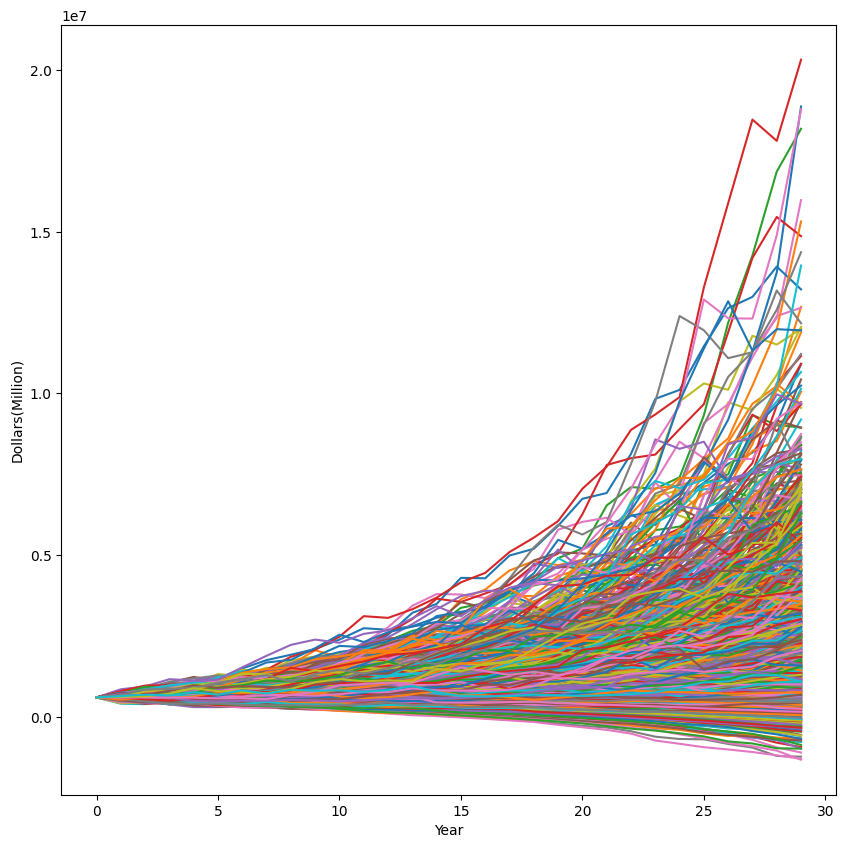

In [112]:
#Plot MonteCarlo for brokerage acct
fig = plt.figure(figsize =(10, 10))

for i in range(YearlyData.shape[0]):
    label = f'data{i}'   # Generate a label for the series
    plt.plot(YearlyData[i,:,0], YearlyData[i,:,1], label=label)

# Add axis labels and legend
plt.xlabel('Year')
plt.ylabel('Dollars(Million)')


# Show the plot
plt.show()

In [ ]:
#MonteCarlo for property
#Distributions
#1YrReturnS&P https://klementoninvesting.substack.com/p/the-distribution-of-stock-market
muMkt = .1
sigmaMkt = .1




#initialization
iterations = 1000
YearlyData = np.zeros([iterations,LTYears,2]) #Layer, row, column
YearlyData[:,0,0] = 0 #Current year 0
YearlyData[:,0,1] = PurchasePrice #InitialAcctValue
i = 0 
j = 1 # j=0 already set above




while i < iterations:
    
    j=1
    while j < (30):
        
        #increment age
        YearlyData[i,j,0] = YearlyData[i,j-1,0] + 1     #Year
    
        #Randomness for market
        sample = np.random.normal(muMkt, sigmaMkt, size=1)
        
        #Calculate acct value
        YearlyData[i,j,1] = YearlyData[i,j-1,1] -LoanPayment*12 +  YearlyData[i,j-1,1]*sample
        
        
        j+=1
    
    i+=1